In [1]:
from utils import load_data, check_gpu, check_dir
from clean_session import preprocess_sessions
import pandas as pd
import numpy as np
from tqdm import tqdm
import gc
import catboost as cat
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:

def plot_imp(data, fold_, plot_n=15):
    check_dir('./imps')
    imp = pd.DataFrame.from_records(data)
    imp.to_csv(f'./imps/{fold_}.csv', index=False)
    imp.columns = ['features', 'feature_importance']
    imp_des = imp.sort_values(by='feature_importance', ascending=False)
    imp_asc = imp.sort_values(by='feature_importance', ascending=True)

    fig, axes = plt.subplots(figsize=(8, 8), nrows=2, ncols=1)
    imp_des[:plot_n].plot(x='features', y='feature_importance', ax=axes[0], kind='barh', grid=True)
    imp_asc[:plot_n].plot(x='features', y='feature_importance', ax=axes[1], kind='barh', grid=True)
    plt.tight_layout()
    fig.savefig('./imps/{}.png'.format(fold_))

In [ ]:
train = load_data('train')#, nrows=10000)

In [ ]:
sub = load_data('submission_popular')

In [ ]:
sub.head()

In [ ]:
sub.shape

In [ ]:
test = load_data('test')#, nrows=10000)

In [ ]:
test = test[test.session_id.isin(sub.session_id.unique())].reset_index(drop=True)

In [ ]:
test.shape

In [ ]:
%time
duplicated_mask = test[[c for c in test.columns if c != 'step']].duplicated(keep='last')
test = test[~duplicated_mask].reset_index(drop=True)

In [ ]:
test.shape

notes: raw test: original shape = (3782335, 12) after drop dups (1795391, 12) |
| sub shape: (253573, 5) | test in sub shape: (3424793, 12) after drop it's (1613617, 13)


In [ ]:
3424793/3424793

In [ ]:
%time
# find duplciates except steps
train.sort_values(by=['user_id', 'session_id', 'timestamp', 'step'], 
                  ascending=[True, True, True, True], 
                  inplace=True)

In [ ]:
train.shape

In [ ]:
%time
duplicated_mask = train[[c for c in train.columns if c != 'step']].duplicated(keep='last')
train = train[~duplicated_mask].reset_index(drop=True)

In [ ]:
train.shape

In [ ]:
train = preprocess_sessions(train, data_source='train')

In [ ]:
# only take the last row
train = train.groupby('session_id').last().reset_index()
del train['action_type'], train['step']
gc.collect()

In [ ]:
train.head()

In [ ]:
train.shape

In [ ]:
# encode city, platform and device
def categorize(df, cols):
    for col in cols:
        print('converting', col)
        unique_values = df[col].unique()
        mapping = {v: k for k, v in enumerate(unique_values)}
        df[col] = df[col].map(mapping)
categorize(train, ['city', 'platform', 'device'])

In [ ]:
# all item id and reference
reference_ids = list(train.reference.unique())
train['nimp'] = train.impressions.str.split('|').str.len()
# pad -1 to impressions length less than 25
train.loc[train.nimp<25, 'impressions'] = train.loc[train.nimp<25].apply(lambda x: f"{x.impressions}|{'|'.join([str(-1) for _ in range(25-x.nimp)])}",
                                                                        axis=1)
train['impression_list'] = train.impressions.str.split('|')
train['nimp'] = train.impressions.str.split('|').str.len()

imp_lists = train.impression_list.values
impression_ids = list(set([j for i in imp_lists for j in i]))

item_ids = list(set(reference_ids + impression_ids))
item_id_mapping = {v: k for k, v in enumerate(item_ids)}


In [ ]:
%time
# map it
train['reference'] = train.reference.map(item_id_mapping)
train['impression_list'] = train.impression_list.apply(lambda imp_list: [item_id_mapping[i] for i in imp_list] )

In [ ]:
train.head()

In [ ]:
def get_index(x):
    if x.reference in x.impression_list:
        return x.impression_list.index(x.reference)
    else:
        return 25
train['target'] = train.apply(get_index, axis=1)

In [ ]:
train = pd.concat([train, pd.DataFrame(train.impression_list.to_list(), columns=[f'loc{i}' for i in range(25)])], axis=1)
del train['impression_list'], train['impressions']

In [ ]:
drop_cols = ['user_id', 'reference', 'current_filters', 'nimp', 'prices']
train.drop(drop_cols, axis=1, inplace=True)

In [ ]:
train.head()

In [ ]:
# take the last 10% timestamp
train.sort_values(by=['timestamp'], inplace=True)
train.reset_index(drop=True, inplace=True)

In [ ]:
# split_per = 0.1
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=2)

sids = train.session_id.values
target = train.target.values
del train['target'], train['timestamp'], train['session_id']


In [ ]:
device = 'GPU' if check_gpu() else 'CPU'
params = {'iterations': 1000,
          'learning_rate': 0.02,
          'depth': 8,
          'task_type': device,
          'loss_function': 'MultiClass',
          'eval_metric': 'Accuracy'}

In [ ]:
cat_fts = [f'loc{i}' for i in range(25)]
cat_fts += ['platform', 'city', 'device']

categorical_ind = [k for k, v in enumerate(train.columns) if v in cat_fts]

for trn_ind, val_ind in skf.split(target, target):
    x_trn, x_val = train.iloc[trn_ind].values, train.iloc[val_ind].values
    y_trn, y_val = target[trn_ind], target[val_ind]
    
    # train model
    clf = cat.CatBoostClassifier(**params)
    clf.fit(x_trn, y_trn,
            cat_features=categorical_ind,
            eval_set=(x_val, y_val),
            early_stopping_rounds=100,
            verbose=100,
            plot=False)
    print('Done!')
    print('Grab feature importance for both train and val')
    # get feature importance
    trn_imp = clf.get_feature_importance(data=cat.Pool(data=x_trn, cat_features=categorical_ind),
                                         prettified=True)
    val_imp = clf.get_feature_importance(data=cat.Pool(data=x_val, cat_features=categorical_ind),
                                         prettified=True)
    plot_imp(trn_imp, 'train')
    plot_imp(val_imp, 'val')
    print('Done feature imp')

#     # make prediction on validation set
#     val_pred = clf.predict_proba(xval.values)[:, 1]
#     logloss_i = log_loss(y_val, val_pred)
#     # compute roc auc
#     fpr, tpr, thresholds = roc_curve(y_val, val_pred, pos_label=1)
#     auc_i = auc(fpr, tpr)
#     # compute map
#     map_i = average_precision_score(y_val, val_pred)
#     print('logloss={0:.4f} | map={1:.4f} | auc={2:.4f}'.format(logloss_i, map_i, auc_i))

#     # mrr
#     print('reciproical rank for validation set')
#     xval['pred'] = val_pred
#     xval['target'] = y_val
#     val_rr = xval.groupby(level=0).apply(reciprocal_rank)
#     mrr = (1/val_rr[val_rr != 0]).mean()
#     print(f'Mean reciporical rank on validation set: {mrr:.4f}')


In [22]:
meta = load_data('item_metadata')

In [ ]:
tids = load_data('train', usecols=['impressions'])

In [ ]:
tids.head()

In [ ]:
tids = tids.dropna()
tids['impressions'] = tids.impressions.str.split('|')
tids = tids.impressions.values
tids = [j for i in tids for j in i]

In [ ]:
tids = list(set(tids))

In [ ]:
tids = [int(i) for i in tids]

In [ ]:
len(tids)

In [ ]:
len(meta.item_id)

In [ ]:
len(set(meta.item_id) - set(tids))

In [ ]:
len(set(tids) - set(meta.item_id))

In [23]:
meta['properties'] = meta.properties.str.lower()
meta['properties'] = meta['properties'].str.split('|')

In [24]:
p_len = meta.properties.str.len()#

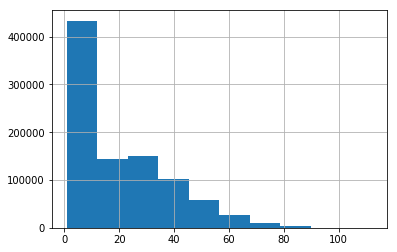

In [25]:
p_len.hist()

In [26]:
p_len.max()

112

In [27]:
properties = meta.properties.values
properties = list(set([j for i in properties for j in i]))

In [65]:
property_mapping = {v: k for k, v in enumerate(properties)}
property_names = list(property_mapping.keys())

In [59]:
# def int_property(property_list):
zeros = np.zeros((len(meta), len(property_mapping.keys())))
zeros.shape

(927142, 157)

In [30]:
meta['properties'] = meta.properties.apply(lambda l: [property_mapping[i] for i in l])

In [32]:
meta.properties.values

array([list([13, 85, 139, 126, 117, 120, 54, 33, 133, 18, 136, 147, 82, 53, 101, 92, 62, 27, 143, 47, 81, 52, 58, 6, 116, 37, 32, 8, 141, 59, 36, 90, 135, 104, 64, 35, 83, 106, 14, 68, 19, 45, 107, 73, 78, 100, 21, 154, 66, 123, 40, 2, 99, 98, 105, 95, 114, 102, 121, 89, 76, 122]),
       list([13, 126, 117, 120, 54, 33, 133, 38, 136, 82, 101, 92, 27, 143, 91, 47, 52, 58, 6, 37, 141, 59, 36, 90, 135, 104, 64, 106, 14, 65, 45, 109, 78, 154, 148, 2, 41, 99, 98, 102, 93, 121, 44, 89, 24, 76]),
       list([13, 126, 117, 120, 54, 133, 92, 48, 27, 143, 91, 81, 52, 58, 6, 37, 9, 141, 59, 104, 64, 106, 14, 109, 145, 156, 78, 21, 130, 41, 99, 98, 105, 102, 67, 121, 89, 24, 76, 122]),
       ..., list([51]), list([51]), list([54])], dtype=object)

In [67]:
a = np.zeros((3,4), dtype=int)

In [68]:
a

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [69]:
a[[[0, 1]], [[1, 2]]] = 1

In [70]:
a

array([[0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0]])

In [60]:
%%time
ps =meta.properties
for i in range(meta.shape[0]):
    zeros[i, ps[i]] = 1

CPU times: user 14.1 s, sys: 263 ms, total: 14.3 s
Wall time: 14.3 s


In [62]:
zeros.sum(axis=1)

array([62., 46., 40., ...,  1.,  1.,  1.])

In [71]:
pd.DataFrame(zeros, columns=property_names, index=meta.item_id).reset_index()

,item_id,shooting sports,casa rural (es),bike rental,swimming pool (indoor),body treatments,farmstay,cot,direct beach access,accessible parking,...,cable tv,sauna,nightclub,sun umbrellas,self catering,jacuzzi (hotel),swimming pool (bar),conference rooms,beauty salon,gay-friendly
0,5101,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,5416,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,5834,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,5910,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,6066,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
5,6094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6288,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
7,6358,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
8,6456,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
9,6561,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
